In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg19, alexnet
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np


In [2]:
# Définir les transformations des images (normalisation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisation sur chaque canal
])

In [3]:
# Chargement des datasets CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Prendre un sous-ensemble des données d'entraînement (par exemple 1% des données)
train_subset_size = int(0.01 * len(trainset))  # 1% des données
train_indices = np.random.choice(len(trainset), train_subset_size, replace=False)  # Échantillonnage aléatoire
trainset_subset = torch.utils.data.Subset(trainset, train_indices)  # Créer un sous-ensemble

# Prendre un sous-ensemble des données de test (par exemple 1% des données)
test_subset_size = int(0.01 * len(testset))  # 1% des données
test_indices = np.random.choice(len(testset), test_subset_size, replace=False)  # Échantillonnage aléatoire
testset_subset = torch.utils.data.Subset(testset, test_indices)  # Créer un sous-ensemble

# Création des DataLoader
trainloader = data.DataLoader(trainset_subset, batch_size=128, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset_subset, batch_size=1, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def compute_layer_cushion_F(A, x):
    """
    Calcul du layer cushion pour une couche donnée du réseau.

    Arguments:
    A -- la matrice de poids (ou tenseur) de la couche (forme : [out_channels, in_channels, kernel_size, kernel_size])
    x -- l'entrée de la couche précédente (forme : [batch_size, in_channels, height, width])

    Retour:
    layer_cushion -- la valeur du layer cushion (μi)
    """

    # 1. Appliquer ReLU sur l'entrée x (couche précédente)
    x_relu = torch.relu(x)

    # 2. Calculer la norme Frobenius de A
    norm_A = torch.norm(A, p='fro')  # Norme Frobenius de A

    # 3. Calculer la norme de l'entrée x après activation (sur tout le batch)
    norm_x = torch.norm(x_relu, p=2)  # Norme L2 de x_relu

    # 4. Effectuer la convolution pour obtenir la sortie de la couche
    with torch.no_grad():  # Désactiver les gradients pour cette étape
        output = torch.nn.functional.conv2d(x_relu, A)  # Appliquer la convolution

    # 5. Calculer la norme de la sortie
    norm_output = torch.norm(output, p=2)  # Norme L2 de la sortie de la couche

    # 6. Calculer le layer cushion (μi)
    layer_cushion = norm_output / (norm_A * norm_x)

    return layer_cushion

In [5]:
def calculate_minimal_interlayer_cushion(A):
    # Calculer le nombre total d'éléments dans la matrice A
    h = np.prod(A.size())  # Nombre total d'éléments dans la matrice A
    # Calcul de 1 / √h
    cushion = 1 / np.sqrt(h)

    return cushion

In [46]:
def compute_interlayer_smoothness(A, x, h_i):
    # Assurez-vous que h_i est un tensor PyTorch
    h_i_tensor = torch.tensor(h_i, dtype=torch.float32)

    # Calculer mu_i_plus_1 (assurez-vous que c'est calculé correctement)
    mu_i_plus_1 = compute_layer_cushion_F(A, x)
    print(mu_i_plus_1)

    # Calculer ρδ
    c = compute_activation_contraction(x)
    rho_delta = torch.sqrt((h_i_tensor * mu_i_plus_1) / c)

    return 1/rho_delta

In [7]:
def compute_layer_cushion_F_ij(A, x, i, j,weights):
    # 1. Appliquer ReLU sur l'entrée x (couche précédente)
    x_init = x
    x_relu = torch.relu(x)
    conv_layers = [f"conv_{iii}" for iii in range(0, 50, 3)]

    # 2. Définir une fonction qui applique la convolution et ReLU
    def layer_forward(x_init):
        x = x_init
        x_relu = torch.relu(x)
  # Appliquer ReLU sur x
        for ii in range(i, j):
            x = F.conv2d(x_relu, weights[conv_layers[ii]])  # Appliquer la convolution
            x_relu = torch.relu(x)   # Appliquer ReLU sur la sortie de la convolution
        return x_relu

    # 3. Calcul de la jacobienne
    jacobian = torch.autograd.functional.jacobian(layer_forward, x_init)
    # 4. Calcul de la norme Frobenius de la jacobienne
    norm_J = torch.norm(jacobian, p='fro')  # Norme Frobenius de la jacobienne

    # 5. Calcul de la norme L2 de x_init
    norm_x = torch.norm(x_init, p=2)  # Norme L2 de x_init

    # 6. Calcul de la norme L2 de x après application de la jacobienne
    norm_JX = torch.norm(torch.matmul(jacobian, x_init), p=2)  # Norme L2 de la multiplication de jacobienne et x_init

    # 7. Calcul du cushion (marge inter-couche)
    layer_cushion = norm_JX / (norm_J * norm_x)

    return layer_cushion


In [1]:
def compute_activation_contraction(x):
  norm_phi = torch.norm(torch.relu(x),p=2)
  norm_x = torch.norm(x,p=2)
  return norm_phi/norm_x


In [10]:
def get_all_weights_conv(model):
    weights = {}

    # Extraire les poids des couches convolutionnelles
    for idx, layer in enumerate(model.features):
        if isinstance(layer, torch.nn.Conv2d):
            weights[f'conv_{idx}'] = layer.weight.data

    return weights

In [26]:
def calculate_layer_cushion_for_dataset(model, trainloader, weigthss,couche):
    """
    Calculer le layer cushion pour plusieurs données dans le trainset.

    Arguments:
    model -- le modèle préentraîné (par exemple, VGG-19)
    trainloader -- DataLoader contenant les données d'entraînement
    device -- le périphérique ('cpu' ou 'cuda') pour les calculs

    Retour:
    layer_cushions -- liste des valeurs des layer cushions pour chaque couche
    """
    model.eval()  # Mode évaluation (désactive le dropout, batchnorm, etc.)

    # Liste pour stocker les résultats des layer cushions
    layer_cushions = []
    activation_contractions = []
    layer_cushions_1i = []
    interlayer_smoothness = []
    conv_layers = list(weigthss.keys())
    # Parcourir le DataLoader
    for inputs, _ in trainloader:
        print("!!")

        # Propager les données à travers chaque couche du modèle
        x = inputs
        i = 0
        for name, module in tqdm(model.named_modules()):  # Récupérer chaque module du modèle
          if isinstance(module, torch.nn.Conv2d):  # Vérifier si c'est une couche Conv2d
              # Passer les entrées à travers la couche actuelle
              print(name)
              x_ = module(x)

              # Calculer le layer cushion pour cette couche
              weight = module.weight  # Matrice de poids de la couche actuelle
              if i != 0 and name == couche:
                  layer_cushion = compute_layer_cushion_F(weight, x)
                  layer_cushions.append(layer_cushion)
                  activation_contraction = compute_activation_contraction(x)
                  activation_contractions.append(activation_contraction)

                  # Calculer le layer cushion entre deux couches
                  layer_cushion_1i = calculate_minimal_interlayer_cushion(weight)
                  layer_cushions_1i.append(layer_cushion_1i)

                  # Si ce n'est pas la dernière couche, obtenir la matrice de poids de la couche suivante
                  if i + 1 < len(list(model.modules())):  # S'assurer qu'il y a un module suivant
                     next_module_w = weigthss[conv_layers[i]]

                     A_ = next_module_w  # Récupérer la matrice de poids du module suivant
                     interlayer = compute_interlayer_smoothness(A_, x_, np.prod(A_.size()))
                     interlayer_smoothness.append(interlayer)

              # Mettre à jour x avec la sortie du module actuel
              x = x_
              i += 1
    return layer_cushions,activation_contractions,layer_cushions_1i,interlayer_smoothness

In [19]:
model_alea = models.vgg19_bn(pretrained=False)
model_train = models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
weights_alea = get_all_weights_conv(model_alea)
weights_train = get_all_weights_conv(model_train)

NameError: name 'get_all_weights_conv' is not defined

In [42]:
weights_alea.keys()

dict_keys(['conv_0', 'conv_3', 'conv_7', 'conv_10', 'conv_14', 'conv_17', 'conv_20', 'conv_23', 'conv_27', 'conv_30', 'conv_33', 'conv_36', 'conv_40', 'conv_43', 'conv_46', 'conv_49'])

In [50]:
layer_cushions_alea, activation_c_alea, mini_cushion_alea,smoothness_alea = calculate_layer_cushion_for_dataset(model_alea, testloader, weights_alea,"features.33")
layer_cushions_train, activation_c_train, mini_cushion_train,smoothness_train = calculate_layer_cushion_for_dataset(model_train, testloader, weights_train,"features.33")


!!


26it [00:00, 217.92it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0435, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 67.85it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 252.80it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0438, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.21it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 252.08it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0429, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46
features.49


64it [00:00, 69.50it/s]


!!


23it [00:00, 182.11it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33


42it [00:00, 44.51it/s] 

tensor(0.0428, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 48.36it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 199.81it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0448, grad_fn=<DivBackward0>)
features.36
features.40


43it [00:00, 40.83it/s] 

features.43
features.46


64it [00:01, 49.81it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 216.70it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 40.60it/s] 

features.43
features.46


64it [00:01, 45.91it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


23it [00:00, 182.42it/s]

features.17
features.20
features.23
features.27
features.30
features.33


42it [00:00, 41.15it/s] 

tensor(0.0429, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 48.57it/s]


features.49
!!


30it [00:00, 264.29it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.92it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 247.46it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0440, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.94it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 229.35it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.28it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 243.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.24it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 263.86it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.37it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 250.22it/s]

features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.29it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 255.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.06it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 245.89it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.19it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17

26it [00:00, 247.08it/s]


features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.39it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 258.97it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.75it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 264.41it/s]

features.23
features.27
features.30
features.33
tensor(0.0438, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.59it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 250.22it/s]

features.23
features.27
features.30
features.33
tensor(0.0438, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.74it/s]


features.46
features.49
!!


30it [00:00, 210.45it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0431, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 53.82it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


26it [00:00, 202.74it/s]

features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:01, 39.12it/s] 

features.43
features.46


64it [00:01, 49.62it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 198.12it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 36.68it/s] 

features.43
features.46


64it [00:01, 46.18it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 194.83it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 37.25it/s] 

features.43
features.46
features.49


64it [00:01, 52.55it/s]


!!


30it [00:00, 242.10it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0441, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.70it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 260.98it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0429, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.33it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 228.03it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0422, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 76.54it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 261.04it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.37it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 263.85it/s]

features.23
features.27
features.30
features.33
tensor(0.0448, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.27it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 231.61it/s]

features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.56it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 258.40it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0446, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.98it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 244.68it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.02it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 254.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0440, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.99it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 249.00it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0448, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.53it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 271.60it/s]

features.23
features.27
features.30
features.33
tensor(0.0441, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.02it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 257.87it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0449, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.43it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 216.19it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0444, grad_fn=<DivBackward0>)
features.36
features.40


48it [00:01, 40.85it/s] 

features.43
features.46


64it [00:01, 49.82it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 207.56it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:00, 41.10it/s] 

features.43
features.46


64it [00:01, 52.19it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


23it [00:00, 225.77it/s]

features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 36.86it/s] 

features.43
features.46


64it [00:01, 46.55it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


23it [00:00, 198.31it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40


43it [00:01, 36.73it/s] 

features.43
features.46


64it [00:01, 44.18it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 224.72it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 70.13it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 260.35it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0426, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.55it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10


30it [00:00, 253.54it/s]

features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0441, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.69it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 235.23it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0431, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.04it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 253.67it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.72it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 248.95it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.83it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 253.54it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.42it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 251.89it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.40it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 229.66it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0452, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.56it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 227.55it/s]

features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.06it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 238.32it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.66it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 257.99it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.13it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 253.83it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 61.25it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 204.60it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0424, grad_fn=<DivBackward0>)
features.36
features.40


44it [00:00, 42.29it/s] 

features.43
features.46


64it [00:01, 49.40it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 229.96it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0429, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 38.67it/s] 

features.43
features.46


64it [00:01, 48.48it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 225.70it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 34.09it/s] 

features.43
features.46


64it [00:01, 43.46it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


23it [00:00, 180.87it/s]

features.17
features.20
features.23
features.27
features.30
features.33


42it [00:00, 56.95it/s] 

tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 65.55it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 248.09it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0435, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.96it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 256.05it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.06it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 256.23it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0449, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.88it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 226.07it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0430, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.75it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 242.65it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.78it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 258.83it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.45it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 243.56it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0427, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.62it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 243.47it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0443, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.17it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14

26it [00:00, 255.11it/s]


features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0440, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.45it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 249.35it/s]

features.23
features.27
features.30
features.33
tensor(0.0446, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.87it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 242.42it/s]

features.23
features.27
features.30
features.33
tensor(0.0435, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.81it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 219.25it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40


48it [00:00, 56.10it/s] 

features.43
features.46


64it [00:01, 63.72it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


26it [00:00, 212.08it/s]

features.23
features.27
features.30
features.33
tensor(0.0435, grad_fn=<DivBackward0>)
features.36
features.40


48it [00:00, 41.83it/s] 

features.43
features.46


64it [00:01, 51.31it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 218.05it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0443, grad_fn=<DivBackward0>)
features.36
features.40


48it [00:01, 40.84it/s] 

features.43
features.46


64it [00:01, 50.42it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 221.32it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 37.18it/s] 

features.43
features.46


64it [00:01, 47.12it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 196.84it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0440, grad_fn=<DivBackward0>)
features.36
features.40


43it [00:00, 37.57it/s] 

features.43
features.46


64it [00:01, 49.64it/s]


features.49
!!


30it [00:00, 250.55it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.43it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 234.29it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.54it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 219.19it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.57it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 255.81it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0447, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.80it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


26it [00:00, 258.08it/s]

features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.44it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 246.49it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.32it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 249.29it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.63it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 247.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.07it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 251.60it/s]

features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.13it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 232.94it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0443, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:00, 80.06it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27


30it [00:00, 234.20it/s]

features.30
features.33
tensor(0.0427, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.87it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 241.05it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0443, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.83it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 247.36it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 54.30it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 204.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0447, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:01, 40.16it/s] 

features.43
features.46


64it [00:01, 50.11it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 202.28it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0439, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:01, 39.12it/s] 

features.43
features.46


64it [00:01, 49.22it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 222.92it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0438, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 36.41it/s] 

features.43
features.46


64it [00:01, 46.41it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 229.06it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0432, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:01, 63.69it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 245.88it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0435, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.88it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 248.31it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0437, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.77it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 248.11it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0434, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 86.03it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 236.69it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0442, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.01it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 245.47it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0430, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.45it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 248.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0429, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.69it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 239.19it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0441, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.12it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 237.20it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.0430, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.63it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 214.87it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0436, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.18it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 240.04it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0431, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.41it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 209.54it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.0433, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.64it/s]

features.46
features.49


!!


26it [00:00, 233.91it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1688, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 56.00it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


23it [00:00, 195.27it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1621, grad_fn=<DivBackward0>)
features.36
features.40


43it [00:00, 41.18it/s] 

features.43
features.46


64it [00:01, 49.35it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 221.77it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1660, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 38.31it/s] 

features.43
features.46


64it [00:01, 48.41it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 203.28it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1611, grad_fn=<DivBackward0>)
features.36
features.40


44it [00:01, 38.30it/s] 

features.43
features.46


64it [00:01, 45.33it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 218.83it/s]

features.20
features.23
features.27
features.30
features.33


45it [00:00, 44.48it/s] 

tensor(0.1679, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46
features.49


64it [00:01, 56.85it/s]


!!


30it [00:00, 245.41it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1667, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.96it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 255.14it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1598, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.54it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 251.17it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1618, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.55it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 239.97it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1621, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.03it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 251.50it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1636, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.93it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 232.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1685, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.31it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 236.41it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1637, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 84.38it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 223.81it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1526, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.38it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.93it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1676, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.10it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.58it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1647, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.56it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 240.28it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1637, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 84.53it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 233.75it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1681, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.66it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 240.39it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1669, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 54.34it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


26it [00:00, 208.35it/s]

features.23
features.27
features.30
features.33
tensor(0.1632, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:00, 42.11it/s] 

features.43
features.46


64it [00:01, 52.49it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 205.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1547, grad_fn=<DivBackward0>)
features.36
features.40


44it [00:00, 42.89it/s] 

features.43
features.46


64it [00:01, 48.75it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


23it [00:00, 226.73it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1648, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 36.11it/s] 

features.43
features.46


64it [00:01, 46.62it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 208.03it/s]

features.20
features.23
features.27
features.30
features.33


44it [00:00, 53.04it/s] 

tensor(0.1684, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 67.59it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20


30it [00:00, 219.17it/s]

features.23
features.27
features.30
features.33
tensor(0.1681, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.70it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 236.47it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1643, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.47it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 246.51it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1583, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:00, 78.82it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27


30it [00:00, 231.15it/s]

features.30
features.33
tensor(0.1649, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.11it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 236.42it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1682, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.31it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 220.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1713, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.24it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 239.13it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1701, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.07it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 235.42it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1624, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.72it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 249.15it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1654, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46
features.49


64it [00:00, 75.21it/s]


!!


30it [00:00, 246.80it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1710, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.77it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 256.48it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1597, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.42it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 237.62it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1607, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46
features.49


64it [00:00, 74.20it/s]


!!


23it [00:00, 223.82it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1667, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:00, 41.00it/s] 

features.43
features.46


64it [00:01, 52.74it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 201.70it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1649, grad_fn=<DivBackward0>)
features.36
features.40


44it [00:00, 44.07it/s] 

features.43
features.46


64it [00:01, 51.95it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 186.88it/s]

features.20
features.23
features.27
features.30
features.33


42it [00:00, 43.97it/s] 

tensor(0.1634, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 46.08it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 219.36it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1548, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 41.36it/s] 

features.43
features.46


64it [00:01, 47.76it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 196.71it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1661, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 69.84it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 252.73it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1685, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.07it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.95it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1538, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.35it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 239.89it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1629, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.87it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 235.83it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1615, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.87it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 245.72it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1659, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.42it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 226.48it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1610, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.78it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 227.24it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1551, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.73it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 241.80it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1681, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:00, 81.38it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27


30it [00:00, 212.05it/s]

features.30
features.33
tensor(0.1605, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.20it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 219.20it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1609, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.73it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 230.52it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1656, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.29it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 242.62it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1650, grad_fn=<DivBackward0>)
features.36
features.40
features.43


51it [00:00, 59.50it/s] 

features.46
features.49


64it [00:00, 71.23it/s]


!!


26it [00:00, 209.23it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1698, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:00, 40.98it/s] 

features.43
features.46


64it [00:01, 51.24it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 218.71it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1622, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 44.92it/s] 

features.43
features.46


64it [00:01, 51.35it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 203.66it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1672, grad_fn=<DivBackward0>)
features.36
features.40


44it [00:00, 39.40it/s] 

features.43
features.46


64it [00:01, 46.36it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 175.55it/s]

features.20
features.23
features.27
features.30
features.33


41it [00:00, 42.10it/s] 

tensor(0.1635, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 47.14it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 213.37it/s]

features.20
features.23
features.27
features.30
features.33


45it [00:00, 57.31it/s] 

tensor(0.1655, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 69.61it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 249.55it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1601, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.93it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 237.92it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1660, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.01it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 259.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1677, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.60it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 239.53it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1691, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.47it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 247.13it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1646, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.12it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.02it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1657, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.00it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 234.38it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1615, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.44it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 230.96it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1570, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 83.02it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 257.29it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1673, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.85it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 230.37it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1707, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.05it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 230.58it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1661, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.16it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.85it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1676, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46
features.49


64it [00:00, 68.97it/s]


!!


23it [00:00, 216.18it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1614, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 45.35it/s] 

features.43
features.46


64it [00:01, 52.45it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 227.76it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1584, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 39.56it/s] 

features.43
features.46


64it [00:01, 50.39it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 194.70it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1620, grad_fn=<DivBackward0>)
features.36
features.40


43it [00:00, 38.40it/s] 

features.43
features.46


64it [00:01, 46.96it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 217.82it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1650, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 40.09it/s] 

features.43
features.46
features.49


64it [00:01, 50.63it/s]


!!


26it [00:00, 257.63it/s]

features.0
features.3
features.7
features.10
features.14
features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1585, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.02it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 250.73it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1616, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.21it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 253.43it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1623, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.59it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 258.57it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1659, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.49it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 232.50it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1681, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.26it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 253.61it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1678, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.81it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 253.73it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1639, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.78it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 226.91it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1653, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.98it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 250.83it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1657, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.37it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 249.52it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1640, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.83it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 233.83it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1702, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.46it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 253.94it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1676, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.92it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 259.66it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1664, grad_fn=<DivBackward0>)
features.36
features.40
features.43
features.46


64it [00:01, 52.64it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 212.95it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1695, grad_fn=<DivBackward0>)
features.36
features.40


45it [00:00, 46.04it/s] 

features.43
features.46


64it [00:01, 51.85it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 222.07it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1689, grad_fn=<DivBackward0>)
features.36
features.40


46it [00:01, 37.96it/s] 

features.43
features.46


64it [00:01, 47.00it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 204.53it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1645, grad_fn=<DivBackward0>)
features.36
features.40


47it [00:01, 37.78it/s] 

features.43
features.46


64it [00:01, 47.75it/s]


features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


23it [00:00, 196.48it/s]

features.20
features.23
features.27
features.30
features.33


43it [00:00, 44.82it/s] 

tensor(0.1661, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:01, 60.36it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 232.38it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1644, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 78.41it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 232.69it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1632, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 82.11it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 241.11it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1675, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.05it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 228.74it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1644, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.19it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


26it [00:00, 248.60it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1684, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.09it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


30it [00:00, 229.63it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1541, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.07it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14


30it [00:00, 224.68it/s]

features.17
features.20
features.23
features.27
features.30
features.33
tensor(0.1677, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.82it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 258.52it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1622, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 80.58it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 252.13it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1645, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 79.95it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 258.70it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1661, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 81.83it/s]


features.46
features.49
!!


0it [00:00, ?it/s]

features.0
features.3
features.7
features.10
features.14
features.17


26it [00:00, 220.57it/s]

features.20
features.23
features.27
features.30
features.33
tensor(0.1668, grad_fn=<DivBackward0>)
features.36
features.40
features.43


64it [00:00, 77.23it/s]

features.46
features.49


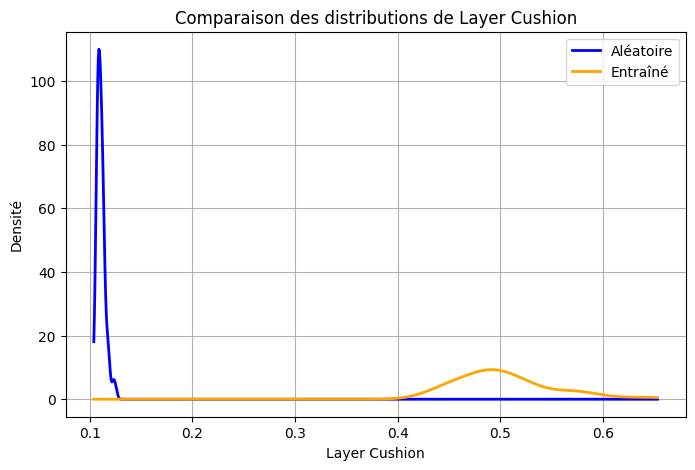

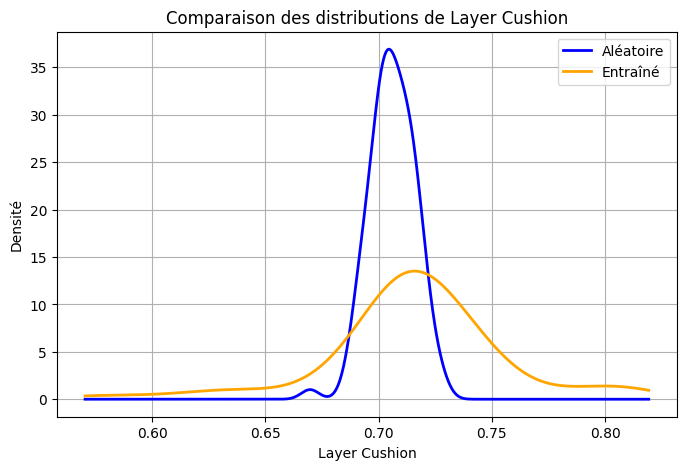

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import gaussian_kde

def plot_density_comparison(data1, data2, label1="Aléatoire", label2="Entraîné", color1="blue", color2="orange"):
    """
    Trace la densité des distributions de deux ensembles de données.

    Arguments :
    - data1, data2 : listes de tenseurs PyTorch (ex: [tensor(0.12), tensor(0.13), ...])
    - label1, label2 : noms des séries de données
    - color1, color2 : couleurs des courbes
    """
    # Convertir les tensors en scalaires
    data1 = [x.item() for x in data1]
    data2 = [x.item() for x in data2]

    plt.figure(figsize=(8, 5))

    # Estimation de la densité (KDE)
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    # Définir la plage de x
    x_min = min(min(data1), min(data2))
    x_max = max(max(data1), max(data2))
    x_range = np.linspace(x_min, x_max, 1000)

    # Tracer les courbes de densité
    plt.plot(x_range, kde1(x_range), color=color1, label=label1, linewidth=2)
    plt.plot(x_range, kde2(x_range), color=color2, label=label2, linewidth=2)

    # Ajout de labels et légende
    plt.xlabel("Layer Cushion")
    plt.ylabel("Densité")
    plt.title("Comparaison des distributions de Layer Cushion")
    plt.legend()
    plt.grid(True)

    # Affichage
    plt.show()

# Appliquer sur tes listes
plot_density_comparison(layer_cushions_alea, layer_cushions_train)
plot_density_comparison(activation_c_alea, activation_c_train)
#plot_density_comparison(mini_cushion_alea, mini_cushion_train)


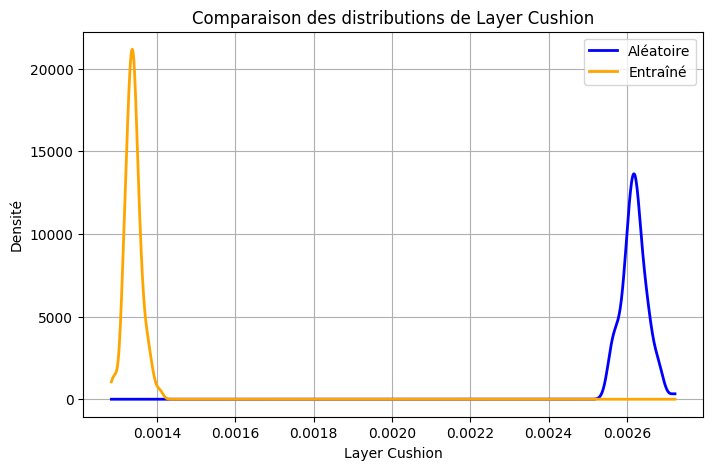

In [51]:
plot_density_comparison(smoothness_alea, smoothness_train)


In [ ]:
#calcule de la borne